In [8]:
# Nama file: 1_ekstraksi_TSFEL_Perintah.py
import os
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm
import tsfel 
import warnings

warnings.filterwarnings('ignore')

# --- Konfigurasi ---
# Ganti ini ke path folder Anda yang berisi /Abdi, /Alex, dll.
DATASET_PATH = "C:\\Dokumen\\PSD\\testing_voice\\data\\dataset-audio" 
COMMANDS = ["buka", "tutup"] 
OUTPUT_CSV = "perintah_features_RAW_tsfel.csv" # Nama file output

try:
    cfg = tsfel.get_features_by_domain()
    print(f"Konfigurasi TSFEL berhasil dimuat.")
except Exception as e:
    print(f"Error saat memuat konfigurasi TSFEL: {e}")
    cfg = None

def extract_tsfel_features(file_path, cfg):
    try:
        audio, sr = librosa.load(file_path, sr=None)
        features_df = tsfel.time_series_features_extractor(cfg, audio, fs=sr, verbose=0) 
        return features_df
    except Exception as e:
        print(f"Error memproses {file_path}: {e}")
        return None

# --- Main Execution ---
if cfg is not None:
    all_data_dfs = [] 
    print(f"Memulai ekstraksi fitur TSFEL dari {DATASET_PATH}...")

    try:
        speakers = [s for s in os.listdir(DATASET_PATH) if os.path.isdir(os.path.join(DATASET_PATH, s))]
    except FileNotFoundError:
        print(f"Error: Path dataset {DATASET_PATH} tidak ditemukan.")
        speakers = []
        
    if not speakers:
        print(f"Tidak ada folder speaker ditemukan.")
    else:
        print(f"Ditemukan speakers: {speakers}")

    for speaker in speakers:
        speaker_path = os.path.join(DATASET_PATH, speaker)
        
        for command in COMMANDS:
            command_path = os.path.join(speaker_path, command)
            
            if not os.path.isdir(command_path):
                continue

            files = [f for f in os.listdir(command_path) if f.endswith('.wav')]
            
            desc = f"Memproses {speaker} -> {command} (TSFEL)"
            for file_name in tqdm(files, desc=desc):
                file_path = os.path.join(command_path, file_name)
                features_df = extract_tsfel_features(file_path, cfg)
                
                if features_df is not None:
                    # Simpan HANYA label perintah
                    features_df['label_perintah'] = command
                    all_data_dfs.append(features_df)

    print("\nEkstraksi fitur TSFEL selesai.")

    if all_data_dfs:
        data = pd.concat(all_data_dfs, ignore_index=True)
        print(f"Data TSFEL diekstrak: {data.shape[0]} baris")
        print(data['label_perintah'].value_counts())

        # --- Pembersihan Data Awal ---
        data.fillna(0, inplace=True)
        feature_cols = [col for col in data.columns if col != 'label_perintah']
        non_variant_cols = [col for col in feature_cols if data[col].nunique() == 1]
        
        if non_variant_cols:
            print(f"Menghapus {len(non_variant_cols)} kolom konstan...")
            data.drop(columns=non_variant_cols, inplace=True)
            
        print(f"Data TSFEL setelah pembersihan: {data.shape[0]} baris, {data.shape[1]} kolom")

        data.to_csv(OUTPUT_CSV, index=False)
        print(f"Berhasil! Data fitur TSFEL telah disimpan ke {OUTPUT_CSV}")
    else:
        print("Tidak ada data TSFEL yang berhasil diekstrak.")
else:
    print("Ekstraksi fitur TSFEL dibatalkan.")

Konfigurasi TSFEL berhasil dimuat.
Memulai ekstraksi fitur TSFEL dari C:\Dokumen\PSD\testing_voice\data\dataset-audio...
Ditemukan speakers: ['Abdi', 'Alex']


Memproses Alex -> tutup (TSFEL): 100%|██████████| 100/100 [00:58<00:00,  1.72it/s]



Ekstraksi fitur TSFEL selesai.
Data TSFEL diekstrak: 400 baris
label_perintah
buka     200
tutup    200
Name: count, dtype: int64
Menghapus 11 kolom konstan...
Data TSFEL setelah pembersihan: 400 baris, 146 kolom
Berhasil! Data fitur TSFEL telah disimpan ke perintah_features_RAW_tsfel.csv


In [9]:
# Nama file: 1_ekstraksi_MFCC_Speaker.py
import os
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm
import warnings

warnings.filterwarnings('ignore')

# --- Konfigurasi ---
DATASET_PATH = "C:\\Dokumen\\PSD\\testing_voice\\data\\dataset-audio" # Sesuaikan path ini
COMMANDS = ["buka", "tutup"]
OUTPUT_CSV = "speaker_features_RAW_mfcc.csv" # Nama file output BARU
N_MFCC = 20 # Kita akan ambil 20 koefisien MFCC

def extract_mfcc_features(file_path, n_mfcc=20):
    """
    Memuat file audio dan mengekstrak rata-rata (mean) DAN 
    standar deviasi (std) dari MFCC.
    """
    try:
        audio, sr = librosa.load(file_path, sr=None)
        
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
        
        mfccs_mean = np.mean(mfccs, axis=1)
        mfccs_std = np.std(mfccs, axis=1)
        
        # Gabungkan (20 mean + 20 std = 40 fitur)
        features = np.concatenate((mfccs_mean, mfccs_std))
        return features
        
    except Exception as e:
        print(f"Error memproses {file_path}: {e}")
        return None

# --- Main Execution ---
all_data = [] 
print(f"Memulai ekstraksi fitur MFCC (untuk Speaker) dari {DATASET_PATH}...")

try:
    speakers = [s for s in os.listdir(DATASET_PATH) if os.path.isdir(os.path.join(DATASET_PATH, s))]
except FileNotFoundError:
    print(f"Error: Path dataset {DATASET_PATH} tidak ditemukan.")
    speakers = []

if not speakers:
    print(f"Tidak ada folder speaker ditemukan.")
else:
    print(f"Ditemukan speakers: {speakers}")

for speaker in speakers:
    speaker_path = os.path.join(DATASET_PATH, speaker)
    
    for command in COMMANDS:
        command_path = os.path.join(speaker_path, command)
        
        if not os.path.isdir(command_path):
            continue

        files = [f for f in os.listdir(command_path) if f.endswith('.wav')]
        
        desc = f"Memproses {speaker} (fitur MFCC)"
        for file_name in tqdm(files, desc=desc):
            file_path = os.path.join(command_path, file_name)
            features = extract_mfcc_features(file_path, n_mfcc=N_MFCC)
            
            if features is not None:
                # Tambahkan fitur dan HANYA label speaker
                all_data.append([*features, speaker])

print("\nEkstraksi fitur MFCC selesai.")

# Buat nama kolom
feature_cols_mean = [f'mfcc_mean_{i+1}' for i in range(N_MFCC)]
feature_cols_std = [f'mfcc_std_{i+1}' for i in range(N_MFCC)]
column_names = feature_cols_mean + feature_cols_std + ['label_speaker']

data = pd.DataFrame(all_data, columns=column_names)
data.fillna(0, inplace=True) 

print(f"Data MFCC diekstrak: {data.shape[0]} baris, {data.shape[1]} kolom")
print(data['label_speaker'].value_counts())

data.to_csv(OUTPUT_CSV, index=False)
print(f"Berhasil! Data fitur speaker (MFCC) telah disimpan ke {OUTPUT_CSV}")

Memulai ekstraksi fitur MFCC (untuk Speaker) dari C:\Dokumen\PSD\testing_voice\data\dataset-audio...
Ditemukan speakers: ['Abdi', 'Alex']


Memproses Alex (fitur MFCC): 100%|██████████| 100/100 [00:01<00:00, 91.64it/s]


Ekstraksi fitur MFCC selesai.
Data MFCC diekstrak: 400 baris, 41 kolom
label_speaker
Abdi    200
Alex    200
Name: count, dtype: int64
Berhasil! Data fitur speaker (MFCC) telah disimpan ke speaker_features_RAW_mfcc.csv


Memuat data dari perintah_features_RAW_tsfel.csv...
Data asli dimuat: 400 baris.
Label 'label_perintah' berhasil di-encode.

Memulai visualisasi PCA 3D (data mentah)...
Membuat plot PCA 3D...
Plot PCA 3D berhasil disimpan ke perintah_pca_3D_RAW.png

Menghitung skor Information Gain untuk 'label_perintah'...
Fitur relevan (skor > 0): 114. Fitur skor 0 (di-drop): 31

Daftar nama fitur ter-ranking disimpan ke perintah_ranked_list.pkl
Berhasil! Data fitur relevan telah disimpan ke perintah_features_RELEVANT.csv


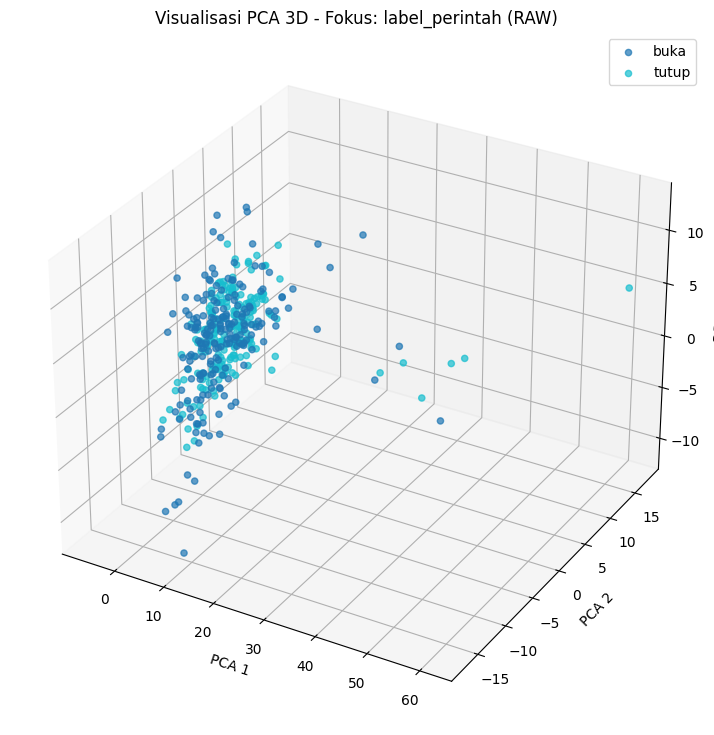

In [10]:
# Nama file: 2_seleksi_PERINTAH.py
import pandas as pd
import numpy as np
import joblib 
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif
# from sklearn.ensemble import IsolationForest <-- DIHAPUS
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# --- Konfigurasi ---
INPUT_CSV = "perintah_features_RAW_tsfel.csv" # <-- Input dari skrip 1a
TARGET_LABEL = "label_perintah" 

# --- Nama File Output ---
OUTPUT_CSV = "perintah_features_RELEVANT.csv" 
RANKED_LIST_PKL = "perintah_ranked_list.pkl" 
PCA_PLOT_FILENAME = "perintah_pca_3D_RAW.png" # <-- Nama file diubah

# --- Main Execution ---
print(f"Memuat data dari {INPUT_CSV}...")
try:
    data = pd.read_csv(INPUT_CSV)
except FileNotFoundError:
    print(f"Error: File {INPUT_CSV} tidak ditemukan. Jalankan skrip 1a dulu.")
    exit()

print(f"Data asli dimuat: {len(data)} baris.")

# --- Pisahkan Fitur (X) dan Label (y) ---
X = data.drop([TARGET_LABEL], axis=1)
y = data[TARGET_LABEL] 
feature_names = X.columns 

# --- BLOK DETEKSI OUTLIER DIHAPUS ---

# --- Encode Label ---
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print(f"Label '{TARGET_LABEL}' berhasil di-encode.")

# --- Visualisasi PCA 3D (data bersih) ---
print("\nMemulai visualisasi PCA 3D (data mentah)...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=3)
pca_components = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(data=pca_components, columns=['PCA 1', 'PCA 2', 'PCA 3'])
pca_df_final = pd.concat([pca_df, y.reset_index(drop=True)], axis=1)

print("Membuat plot PCA 3D...")
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d') 
labels = pca_df_final[TARGET_LABEL].unique()
colors = plt.cm.get_cmap('tab10', len(labels)) 
color_map = {label: colors(i) for i, label in enumerate(labels)}
for label, color in color_map.items():
    subset = pca_df_final[pca_df_final[TARGET_LABEL] == label]
    ax.scatter(subset['PCA 1'], subset['PCA 2'], subset['PCA 3'], c=[color], label=label, alpha=0.7)
ax.set_title(f'Visualisasi PCA 3D - Fokus: {TARGET_LABEL} (RAW)') # <-- Judul diubah
ax.set_xlabel('PCA 1'); ax.set_ylabel('PCA 2'); ax.set_zlabel('PCA 3'); ax.legend(loc='best'); plt.grid(True)
plt.savefig(PCA_PLOT_FILENAME)
print(f"Plot PCA 3D berhasil disimpan ke {PCA_PLOT_FILENAME}\n")

# --- Hitung Skor Information Gain ---
print(f"Menghitung skor Information Gain untuk '{TARGET_LABEL}'...")
mi_scores = mutual_info_classif(X, y_encoded, random_state=42)
feature_scores = pd.Series(mi_scores, index=feature_names).sort_values(ascending=False)
relevant_features = feature_scores[feature_scores > 0]
dropped_features_count = len(feature_scores) - len(relevant_features)
print(f"Fitur relevan (skor > 0): {len(relevant_features)}. Fitur skor 0 (di-drop): {dropped_features_count}\n")

# --- Simpan Daftar Fitur Ter-ranking ---
ranked_feature_list = relevant_features.index.tolist()
joblib.dump(ranked_feature_list, RANKED_LIST_PKL)
print(f"Daftar nama fitur ter-ranking disimpan ke {RANKED_LIST_PKL}")

# --- Simpan DataFrame Baru ---
final_columns = ranked_feature_list + [TARGET_LABEL]
data_final = data[final_columns]
data_final.to_csv(OUTPUT_CSV, index=False)
print(f"Berhasil! Data fitur relevan telah disimpan ke {OUTPUT_CSV}")

Memuat data dari perintah_features_RELEVANT.csv...
Label encoder disimpan ke encoder_perintah.pkl
Data dibagi: 320 latih, 80 uji.

Memulai iterasi training untuk 'label_perintah'...


Mencari Fitur Terbaik: 100%|██████████| 114/114 [00:27<00:00,  4.13it/s]


Iterasi training selesai.

--- Hasil Analisis 'label_perintah' ---
Akurasi tertinggi adalah 97.50%
Didapatkan saat menggunakan Top 77 fitur.
------------------------

Membuat visualisasi statistik akurasi...
Plot statistik disimpan ke perintah_akurasi_vs_fitur.png

Melatih model FINAL dengan Top 77 fitur terbaik...
Model final selesai dilatih.
Model final disimpan ke model_perintah.pkl
Daftar 77 fitur terbaik disimpan ke features_perintah.pkl

Memulai visualisasi PCA 3D untuk fitur-fitur terbaik...
Membuat plot PCA final 3D...
Plot PCA final 3D berhasil disimpan ke perintah_pca_3D_TERBAIK.png

--- Proses Pelatihan 'label_perintah' Selesai ---


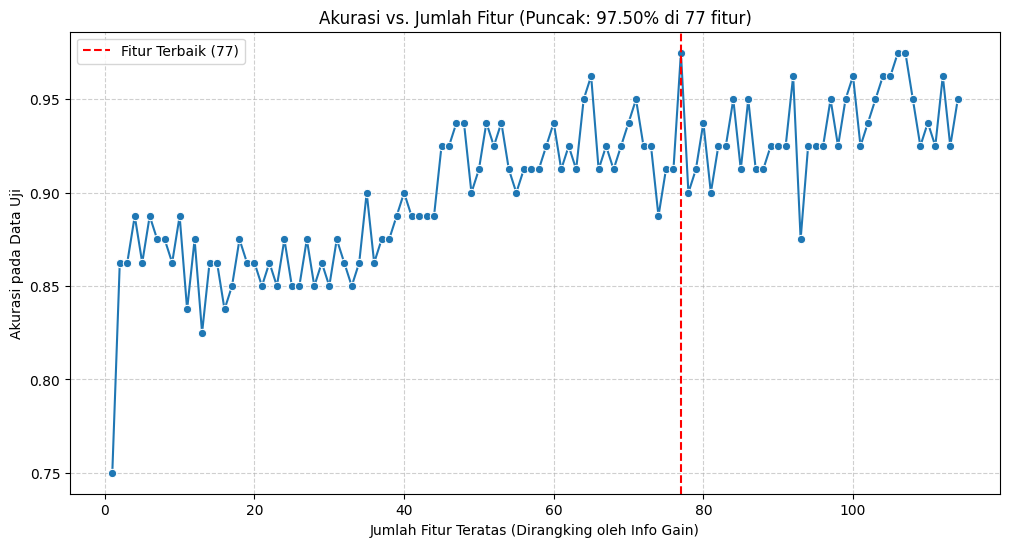

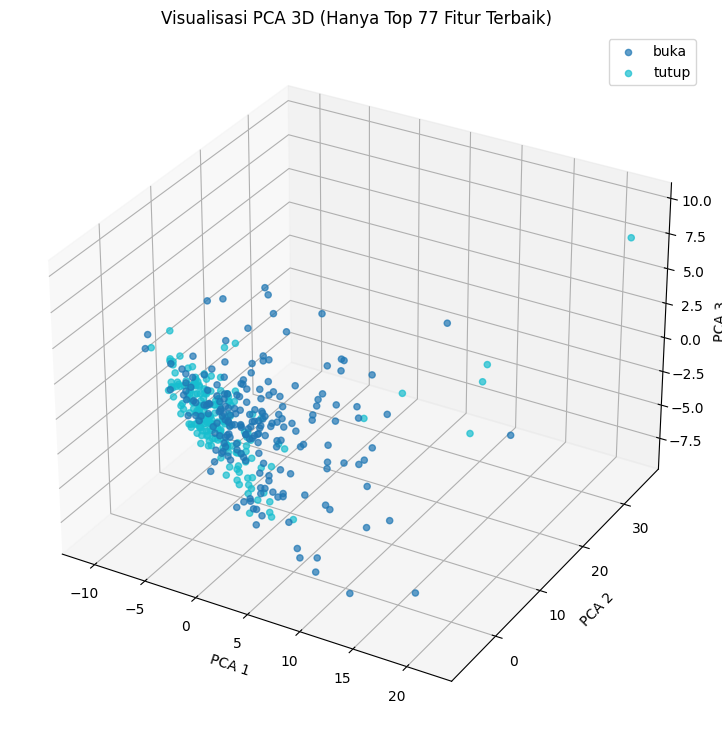

In [11]:
# Nama file: 3_model_PERINTAH.py
import pandas as pd
import joblib
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm 
from sklearn.decomposition import PCA
import warnings

warnings.filterwarnings('ignore')

# --- Konfigurasi ---
INPUT_CSV = "perintah_features_RELEVANT.csv" # <-- Input dari skrip 2a
RANKED_LIST_PKL = "perintah_ranked_list.pkl"  # <-- Input dari skrip 2a
TARGET_LABEL = "label_perintah" 

# --- Nama File Output ---
MODEL_PKL = "model_perintah.pkl"     
FEATURES_PKL = "features_perintah.pkl"  
ENCODER_PKL = "encoder_perintah.pkl"
PLOT_ACC_FILENAME = "perintah_akurasi_vs_fitur.png"
PLOT_PCA_FINAL_FILENAME = "perintah_pca_3D_TERBAIK.png"

# --- 1. Muat Data dan Daftar Fitur ---
print(f"Memuat data dari {INPUT_CSV}...")
try:
    data = pd.read_csv(INPUT_CSV)
    ranked_feature_list = joblib.load(RANKED_LIST_PKL)
except FileNotFoundError:
    print(f"Error: File tidak ditemukan. Jalankan skrip 2a dulu.")
    exit()
    
# --- 2. Pisahkan Fitur (X) dan Label (y) ---
X = data.drop([TARGET_LABEL], axis=1, errors='ignore') 
y = data[TARGET_LABEL]

# --- 3. Encode Label ---
le = LabelEncoder()
y_encoded = le.fit_transform(y)
joblib.dump(le, ENCODER_PKL) 
print(f"Label encoder disimpan ke {ENCODER_PKL}")

# --- 4. Bagi Data (Train/Test Split) ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)
print(f"Data dibagi: {len(X_train)} latih, {len(X_test)} uji.")

# --- 5. Loop Training untuk Menemukan Fitur Terbaik ---
num_total_features = len(ranked_feature_list) 
accuracies = [] 
print(f"\nMemulai iterasi training untuk '{TARGET_LABEL}'...")
for k in tqdm(range(num_total_features, 0, -1), desc="Mencari Fitur Terbaik"):
    current_features = ranked_feature_list[:k]
    X_train_subset = X_train[current_features]
    X_test_subset = X_test[current_features]
    
    model = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
    model.fit(X_train_subset, y_train)
    
    y_pred = model.predict(X_test_subset)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append((k, acc))
print("Iterasi training selesai.")

# --- 6. Analisis Hasil Iterasi ---
results_df = pd.DataFrame(accuracies, columns=['Num_Features', 'Accuracy']).sort_values(by='Num_Features') 
best_result = results_df.loc[results_df['Accuracy'].idxmax()]
best_k = int(best_result['Num_Features'])
best_accuracy = best_result['Accuracy']
print(f"\n--- Hasil Analisis '{TARGET_LABEL}' ---")
print(f"Akurasi tertinggi adalah {best_accuracy * 100:.2f}%")
print(f"Didapatkan saat menggunakan Top {best_k} fitur.")
print("------------------------\n")

# --- 7. Visualisasi Statistik Akurasi (2D) ---
print("Membuat visualisasi statistik akurasi...")
plt.figure(figsize=(12, 6))
sns.lineplot(data=results_df, x='Num_Features', y='Accuracy', marker='o') 
plt.title(f'Akurasi vs. Jumlah Fitur (Puncak: {best_accuracy*100:.2f}% di {best_k} fitur)')
plt.xlabel('Jumlah Fitur Teratas (Dirangking oleh Info Gain)'); plt.ylabel('Akurasi pada Data Uji')
plt.grid(True, linestyle='--', alpha=0.6); plt.axvline(x=best_k, color='red', linestyle='--', label=f'Fitur Terbaik ({best_k})'); plt.legend()
plt.savefig(PLOT_ACC_FILENAME)
print(f"Plot statistik disimpan ke {PLOT_ACC_FILENAME}")

# --- 8. Latih dan Simpan Model FINAL ---
print(f"\nMelatih model FINAL dengan Top {best_k} fitur terbaik...")
final_feature_list = ranked_feature_list[:best_k]
X_final = X[final_feature_list] 
final_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
final_model.fit(X_final, y_encoded) 
print("Model final selesai dilatih.")
joblib.dump(final_model, MODEL_PKL)
print(f"Model final disimpan ke {MODEL_PKL}")
joblib.dump(final_feature_list, FEATURES_PKL)
print(f"Daftar {best_k} fitur terbaik disimpan ke {FEATURES_PKL}")

# --- 9. Visualisasi PCA Final 3D (dengan Fitur Terbaik) ---
print("\nMemulai visualisasi PCA 3D untuk fitur-fitur terbaik...")
scaler = StandardScaler()
X_final_scaled = scaler.fit_transform(X_final) 
pca = PCA(n_components=3) 
pca_components_final = pca.fit_transform(X_final_scaled)
pca_df = pd.DataFrame(data=pca_components_final, columns=['PCA 1', 'PCA 2', 'PCA 3'])
pca_df_final = pd.concat([pca_df, y.reset_index(drop=True)], axis=1)

print("Membuat plot PCA final 3D...")
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d') 
labels = pca_df_final[TARGET_LABEL].unique()
colors = plt.cm.get_cmap('tab10', len(labels)) 
color_map = {label: colors(i) for i, label in enumerate(labels)}
for label, color in color_map.items():
    subset = pca_df_final[pca_df_final[TARGET_LABEL] == label]
    ax.scatter(subset['PCA 1'], subset['PCA 2'], subset['PCA 3'], c=[color], label=label, alpha=0.7)
ax.set_title(f'Visualisasi PCA 3D (Hanya Top {best_k} Fitur Terbaik)')
ax.set_xlabel('PCA 1'); ax.set_ylabel('PCA 2'); ax.set_zlabel('PCA 3'); ax.legend(loc='best'); plt.grid(True)
plt.savefig(PLOT_PCA_FINAL_FILENAME)
print(f"Plot PCA final 3D berhasil disimpan ke {PLOT_PCA_FINAL_FILENAME}\n")
print(f"--- Proses Pelatihan '{TARGET_LABEL}' Selesai ---")

Memuat data dari speaker_features_RAW_mfcc.csv...
Data asli dimuat: 400 baris.
Label 'label_speaker' berhasil di-encode.

Memulai visualisasi PCA 3D (data mentah)...
Membuat plot PCA 3D...
Plot PCA 3D berhasil disimpan ke speaker_pca_3D_RAW.png

Menghitung skor Information Gain untuk 'label_speaker'...
Fitur relevan (skor > 0): 39. Fitur skor 0 (di-drop): 1

Daftar nama fitur ter-ranking disimpan ke speaker_ranked_list.pkl
Berhasil! Data fitur relevan telah disimpan ke speaker_features_RELEVANT.csv


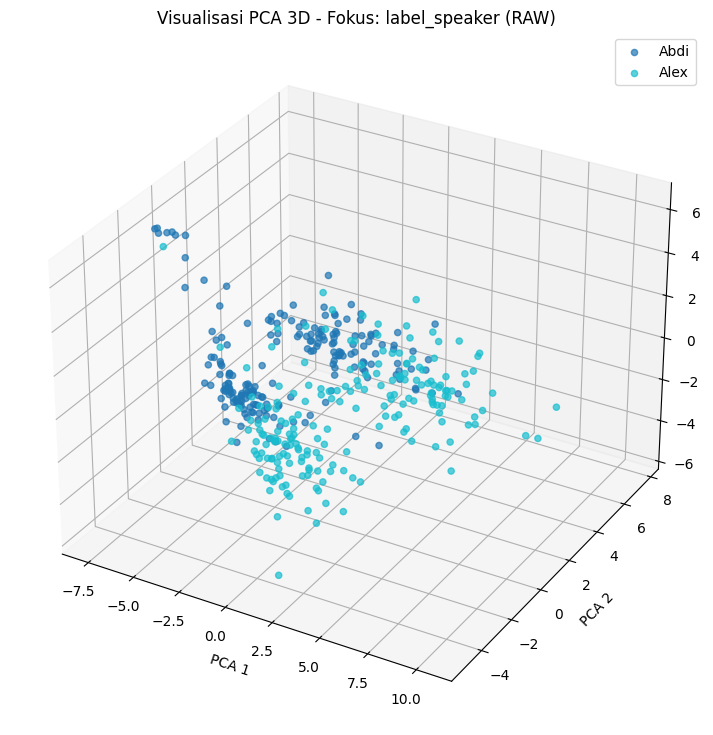

In [12]:
# Nama file: 2_seleksi_SPEAKER.py
import pandas as pd
import numpy as np
import joblib 
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif
# from sklearn.ensemble import IsolationForest <-- DIHAPUS
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# --- Konfigurasi ---
INPUT_CSV = "speaker_features_RAW_mfcc.csv" # <-- Input dari skrip 1b
TARGET_LABEL = "label_speaker" 

# --- Nama File Output ---
OUTPUT_CSV = "speaker_features_RELEVANT.csv" 
RANKED_LIST_PKL = "speaker_ranked_list.pkl" 
PCA_PLOT_FILENAME = "speaker_pca_3D_RAW.png" # <-- Nama file diubah

# --- Main Execution ---
print(f"Memuat data dari {INPUT_CSV}...")
try:
    data = pd.read_csv(INPUT_CSV)
except FileNotFoundError:
    print(f"Error: File {INPUT_CSV} tidak ditemukan. Jalankan skrip 1b dulu.")
    exit()

print(f"Data asli dimuat: {len(data)} baris.")

# --- Pisahkan Fitur (X) dan Label (y) ---
X = data.drop([TARGET_LABEL], axis=1)
y = data[TARGET_LABEL] 
feature_names = X.columns 

# --- BLOK DETEKSI OUTLIER DIHAPUS ---

# --- Encode Label ---
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print(f"Label '{TARGET_LABEL}' berhasil di-encode.")

# --- Visualisasi PCA 3D (data bersih) ---
print("\nMemulai visualisasi PCA 3D (data mentah)...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=3)
pca_components = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(data=pca_components, columns=['PCA 1', 'PCA 2', 'PCA 3'])
pca_df_final = pd.concat([pca_df, y.reset_index(drop=True)], axis=1)

print("Membuat plot PCA 3D...")
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d') 
labels = pca_df_final[TARGET_LABEL].unique()
colors = plt.cm.get_cmap('tab10', len(labels)) 
color_map = {label: colors(i) for i, label in enumerate(labels)}
for label, color in color_map.items():
    subset = pca_df_final[pca_df_final[TARGET_LABEL] == label]
    ax.scatter(subset['PCA 1'], subset['PCA 2'], subset['PCA 3'], c=[color], label=label, alpha=0.7)
ax.set_title(f'Visualisasi PCA 3D - Fokus: {TARGET_LABEL} (RAW)') # <-- Judul diubah
ax.set_xlabel('PCA 1'); ax.set_ylabel('PCA 2'); ax.set_zlabel('PCA 3'); ax.legend(loc='best'); plt.grid(True)
plt.savefig(PCA_PLOT_FILENAME)
print(f"Plot PCA 3D berhasil disimpan ke {PCA_PLOT_FILENAME}\n")

# --- Hitung Skor Information Gain ---
print(f"Menghitung skor Information Gain untuk '{TARGET_LABEL}'...")
mi_scores = mutual_info_classif(X, y_encoded, random_state=42)
feature_scores = pd.Series(mi_scores, index=feature_names).sort_values(ascending=False)
relevant_features = feature_scores[feature_scores > 0]
dropped_features_count = len(feature_scores) - len(relevant_features)
print(f"Fitur relevan (skor > 0): {len(relevant_features)}. Fitur skor 0 (di-drop): {dropped_features_count}\n")

# --- Simpan Daftar Fitur Ter-ranking ---
ranked_feature_list = relevant_features.index.tolist()
joblib.dump(ranked_feature_list, RANKED_LIST_PKL)
print(f"Daftar nama fitur ter-ranking disimpan ke {RANKED_LIST_PKL}")

# --- Simpan DataFrame Baru ---
final_columns = ranked_feature_list + [TARGET_LABEL]
data_final = data[final_columns]
data_final.to_csv(OUTPUT_CSV, index=False)
print(f"Berhasil! Data fitur relevan telah disimpan ke {OUTPUT_CSV}")

Memuat data dari speaker_features_RELEVANT.csv...
Label encoder disimpan ke encoder_speaker.pkl
Data dibagi: 320 latih, 80 uji.

Memulai iterasi training untuk 'label_speaker'...


Mencari Fitur Terbaik: 100%|██████████| 39/39 [00:09<00:00,  4.08it/s]


Iterasi training selesai.

--- Hasil Analisis 'label_speaker' ---
Akurasi tertinggi adalah 100.00%
Didapatkan saat menggunakan Top 3 fitur.
------------------------

Membuat visualisasi statistik akurasi...
Plot statistik disimpan ke speaker_akurasi_vs_fitur.png

Melatih model FINAL dengan Top 3 fitur terbaik...
Model final selesai dilatih.
Model final disimpan ke model_speaker.pkl
Daftar 3 fitur terbaik disimpan ke features_speaker.pkl

Memulai visualisasi PCA 3D untuk fitur-fitur terbaik...
Membuat plot PCA final 3D...
Plot PCA final 3D berhasil disimpan ke speaker_pca_3D_TERBAIK.png

--- Proses Pelatihan 'label_speaker' Selesai ---


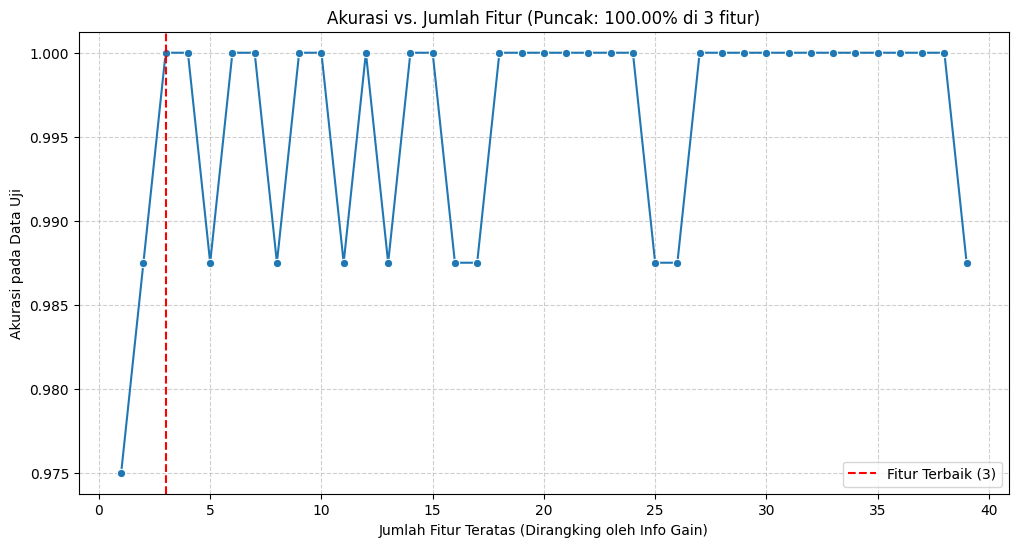

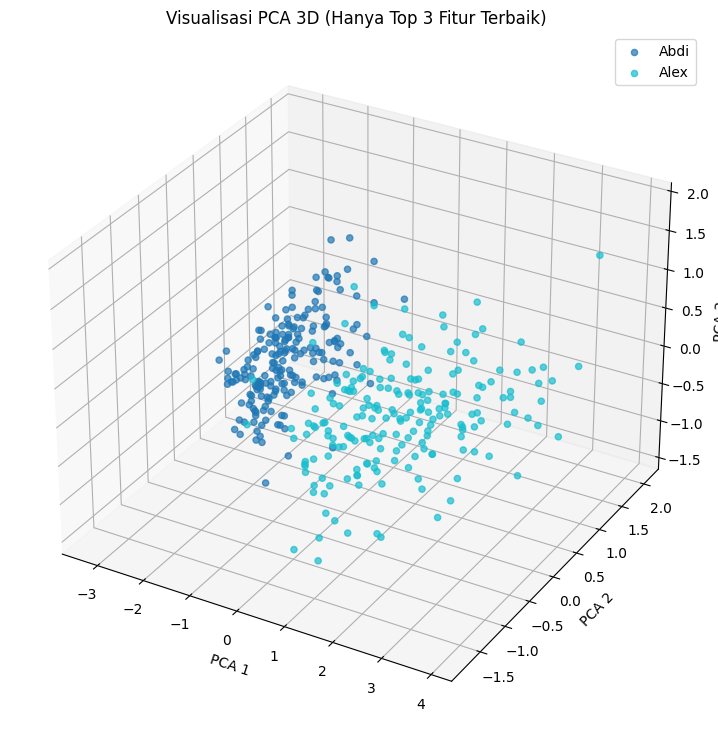

In [13]:
# Nama file: 3_model_SPEAKER.py
import pandas as pd
import joblib
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm 
from sklearn.decomposition import PCA
import warnings

warnings.filterwarnings('ignore')

# --- Konfigurasi ---
INPUT_CSV = "speaker_features_RELEVANT.csv" # <-- Input dari skrip 2b
RANKED_LIST_PKL = "speaker_ranked_list.pkl"  # <-- Input dari skrip 2b
TARGET_LABEL = "label_speaker" 

# --- Nama File Output ---
MODEL_PKL = "model_speaker.pkl"     
FEATURES_PKL = "features_speaker.pkl"  
ENCODER_PKL = "encoder_speaker.pkl"
PLOT_ACC_FILENAME = "speaker_akurasi_vs_fitur.png"
PLOT_PCA_FINAL_FILENAME = "speaker_pca_3D_TERBAIK.png"

# --- 1. Muat Data dan Daftar Fitur ---
print(f"Memuat data dari {INPUT_CSV}...")
try:
    data = pd.read_csv(INPUT_CSV)
    ranked_feature_list = joblib.load(RANKED_LIST_PKL)
except FileNotFoundError:
    print(f"Error: File tidak ditemukan. Jalankan skrip 2b dulu.")
    exit()
    
# --- 2. Pisahkan Fitur (X) dan Label (y) ---
X = data.drop([TARGET_LABEL], axis=1, errors='ignore') 
y = data[TARGET_LABEL] 

# --- 3. Encode Label ---
le = LabelEncoder()
y_encoded = le.fit_transform(y)
joblib.dump(le, ENCODER_PKL) 
print(f"Label encoder disimpan ke {ENCODER_PKL}")

# --- 4. Bagi Data (Train/Test Split) ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)
print(f"Data dibagi: {len(X_train)} latih, {len(X_test)} uji.")

# --- 5. Loop Training untuk Menemukan Fitur Terbaik ---
num_total_features = len(ranked_feature_list) 
accuracies = [] 
print(f"\nMemulai iterasi training untuk '{TARGET_LABEL}'...")
for k in tqdm(range(num_total_features, 0, -1), desc="Mencari Fitur Terbaik"):
    current_features = ranked_feature_list[:k]
    X_train_subset = X_train[current_features]
    X_test_subset = X_test[current_features]
    
    model = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
    model.fit(X_train_subset, y_train)
    
    y_pred = model.predict(X_test_subset)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append((k, acc))
print("Iterasi training selesai.")

# --- 6. Analisis Hasil Iterasi ---
results_df = pd.DataFrame(accuracies, columns=['Num_Features', 'Accuracy']).sort_values(by='Num_Features') 
best_result = results_df.loc[results_df['Accuracy'].idxmax()]
best_k = int(best_result['Num_Features'])
best_accuracy = best_result['Accuracy']
print(f"\n--- Hasil Analisis '{TARGET_LABEL}' ---")
print(f"Akurasi tertinggi adalah {best_accuracy * 100:.2f}%")
print(f"Didapatkan saat menggunakan Top {best_k} fitur.")
print("------------------------\n")

# --- 7. Visualisasi Statistik Akurasi (2D) ---
print("Membuat visualisasi statistik akurasi...")
plt.figure(figsize=(12, 6))
sns.lineplot(data=results_df, x='Num_Features', y='Accuracy', marker='o') 
plt.title(f'Akurasi vs. Jumlah Fitur (Puncak: {best_accuracy*100:.2f}% di {best_k} fitur)')
plt.xlabel('Jumlah Fitur Teratas (Dirangking oleh Info Gain)'); plt.ylabel('Akurasi pada Data Uji')
plt.grid(True, linestyle='--', alpha=0.6); plt.axvline(x=best_k, color='red', linestyle='--', label=f'Fitur Terbaik ({best_k})'); plt.legend()
plt.savefig(PLOT_ACC_FILENAME)
print(f"Plot statistik disimpan ke {PLOT_ACC_FILENAME}")

# --- 8. Latih dan Simpan Model FINAL ---
print(f"\nMelatih model FINAL dengan Top {best_k} fitur terbaik...")
final_feature_list = ranked_feature_list[:best_k]
X_final = X[final_feature_list] 
final_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
final_model.fit(X_final, y_encoded) 
print("Model final selesai dilatih.")
joblib.dump(final_model, MODEL_PKL)
print(f"Model final disimpan ke {MODEL_PKL}")
joblib.dump(final_feature_list, FEATURES_PKL)
print(f"Daftar {best_k} fitur terbaik disimpan ke {FEATURES_PKL}")

# --- 9. Visualisasi PCA Final 3D (dengan Fitur Terbaik) ---

# TAMBAHKAN PENGECEKAN INI
if best_k >= 3:
    print("\nMemulai visualisasi PCA 3D untuk fitur-fitur terbaik...")
    scaler = StandardScaler()
    X_final_scaled = scaler.fit_transform(X_final) 
    pca = PCA(n_components=3) 
    pca_components_final = pca.fit_transform(X_final_scaled)
    pca_df = pd.DataFrame(data=pca_components_final, columns=['PCA 1', 'PCA 2', 'PCA 3'])
    pca_df_final = pd.concat([pca_df, y.reset_index(drop=True)], axis=1)

    print("Membuat plot PCA final 3D...")
    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(111, projection='3d') 
    labels = pca_df_final[TARGET_LABEL].unique()
    colors = plt.cm.get_cmap('tab10', len(labels)) 
    color_map = {label: colors(i) for i, label in enumerate(labels)}
    for label, color in color_map.items():
        subset = pca_df_final[pca_df_final[TARGET_LABEL] == label]
        ax.scatter(subset['PCA 1'], subset['PCA 2'], subset['PCA 3'], c=[color], label=label, alpha=0.7)
    ax.set_title(f'Visualisasi PCA 3D (Hanya Top {best_k} Fitur Terbaik)')
    ax.set_xlabel('PCA 1'); ax.set_ylabel('PCA 2'); ax.set_zlabel('PCA 3'); ax.legend(loc='best'); plt.grid(True)
    plt.savefig(PLOT_PCA_FINAL_FILENAME)
    print(f"Plot PCA final 3D berhasil disimpan ke {PLOT_PCA_FINAL_FILENAME}\n")
    
else:
    # TAMBAHKAN BLOK 'ELSE' INI
    print(f"\nVisualisasi PCA 3D dilewati karena fitur terbaik ({best_k}) kurang dari 3.")

print(f"--- Proses Pelatihan '{TARGET_LABEL}' Selesai ---")